Welcome to the torchkbnufft demo! Let's get started...

# Data Loading and Formatting
First, we need to load some data. For this we can use scipy.io to load a matlab file with complex k-space data.

In [1]:
import scipy.io as sio

obj = sio.loadmat('demo_data.mat')
kdata_np, ktraj_np, smap_np = obj['kdata'], obj['ktraj'], obj['smap']

Let's look at the size of this data set...

In [2]:
print('kdata size: {}'.format(kdata_np.shape))
print('ktraj size: {}'.format(ktraj_np.shape))
print('smap size: {}'.format(smap_np.shape))

kdata size: (8, 405, 512)
ktraj size: (2, 405, 512)
smap size: (8, 256, 256)


This is a radial data set, so we have 405 spokes, each of length 512. In this case we've already calculated the sensitivity maps, but in practical settings you'll need to calculate them on your own.

In order to use TorchKbNufft, we need to reshape this data so the k-space points are in a single vector. We also need to unsqueeze a batch dimension. Finally, we need to separate real and imaginary components.

In [3]:
import torch
import numpy as np

# this "stacks" real and imaginary components along the second dimension
print('stacking real/imaginary...')
kdata = torch.stack((torch.tensor(np.real(kdata_np)), torch.tensor(np.imag(kdata_np))), dim=1)
ktraj = torch.tensor(ktraj_np)
print('kdata shape: {}'.format(kdata.shape))
print('ktraj shape: {}'.format(ktraj.shape))

# flatten k-space coordinates...
print('flattening k-space')
kdata = kdata.view(kdata.shape[0], kdata.shape[1], -1)
ktraj = ktraj.view(ktraj.shape[0], -1)
print('kdata shape: {}'.format(kdata.shape))
print('ktraj shape: {}'.format(ktraj.shape))

# unsqueeze the batch dimension
print('unsqueezing batch...')
kdata = kdata.unsqueeze(0)
ktraj = ktraj.unsqueeze(0)
print('kdata shape: {}'.format(kdata.shape))
print('ktraj shape: {}'.format(ktraj.shape))

stacking real/imaginary...
kdata shape: torch.Size([8, 2, 405, 512])
ktraj shape: torch.Size([2, 405, 512])
flattening k-space
kdata shape: torch.Size([8, 2, 207360])
ktraj shape: torch.Size([2, 207360])
unsqueezing batch...
kdata shape: torch.Size([1, 8, 2, 207360])
ktraj shape: torch.Size([1, 2, 207360])


We also need to convert the sensitivity maps to a tensor...

In [4]:
smap = torch.stack((torch.tensor(np.real(smap_np)), torch.tensor(np.imag(smap_np))), dim=1)
smap = smap.unsqueeze(0)
print('smap shape: {}'.format(smap.shape))

smap shape: torch.Size([1, 8, 2, 256, 256])


# Adjoint SENSE NUFFTs

Now we're ready to use the package!

Using TorchKbNufft is essentially the same as using PyTorch. First, you define a layer (either a forward or adjoint NUFFT). Then, you can apply that layer.

In [5]:
from torchkbnufft import AdjMriSenseNufft, MriSenseNufft

nufft = MriSenseNufft(smap=smap, im_size=tuple(smap.shape[-2:])).to(smap.dtype)
adjnufft = AdjMriSenseNufft(smap=smap, im_size=tuple(smap.shape[-2:])).to(smap.dtype)
print(adjnufft)


AdjMriSenseNufft
----------------------------------------
   training: True
   im_size: (256, 256)
   grid_size: (512, 512)
   n_shift: (128, 128)
   numpoints: (6, 6)
   alpha: (14.04, 14.04)
   order: (0, 0)
   table: 2 arrays, lengths: (1024, 1024)
   scaling_coef: (256, 256) float64 array
   norm: None
   coil_broadcast: False
   coilpack: False
   matadj: False
   smap_shape: torch.Size([1, 8, 2, 256, 256])



Let's use the NUFFT and plot!

In [6]:
from plot_helper import plot_helper

image = adjnufft(kdata, ktraj)
print('image size: {}'.format(image.shape))

plot_helper(image)

image size: torch.Size([1, 1, 2, 256, 256])


<Figure size 640x480 with 1 Axes>

We can improve the image with some density compensation...

In [7]:
from torchkbnufft.mri.dcomp_calc import calculate_radial_dcomp_pytorch

dcomp = calculate_radial_dcomp_pytorch(nufft, adjnufft, ktraj).unsqueeze(0).unsqueeze(0)

print('dcomp size: {}'.format(dcomp.shape))

dcomp size: torch.Size([1, 1, 1, 207360])


image size: torch.Size([1, 1, 2, 256, 256])


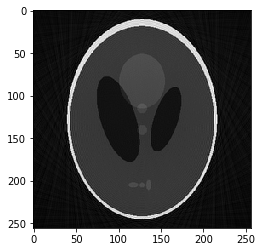

In [8]:
image = adjnufft(kdata * dcomp, ktraj)
print('image size: {}'.format(image.shape))

plot_helper(image)

# Sparse Matrix Mode

The operation we just covered uses table interpolation. In many cases, using sparse matrices as a backend can be faster. We can easily use sparse matrices in TorchKbNufft with a simple precomputation step.

image size: torch.Size([1, 1, 2, 256, 256])


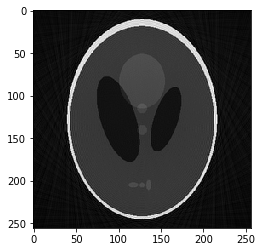

In [9]:
from torchkbnufft.nufft.sparse_interp_mat import precomp_sparse_mats

# calculation of sparse interpolation matrices
real_mat, imag_mat = precomp_sparse_mats(ktraj, adjnufft)
interp_mats = {
    'real_interp_mats': real_mat,
    'imag_interp_mats': imag_mat
}

# just pass them into the function - use is automatic
image = adjnufft(kdata * dcomp, ktraj, interp_mats)
print('image size: {}'.format(image.shape))

plot_helper(image)

# Toeplitz forward/backward NUFFTs

Toeplitz NUFFTs are a very fast way to compute forward/backward nuffts without any interpolation steps. They only require precalculation of an FFT filter.

In [10]:
from torchkbnufft.nufft.toep_functions import calc_toep_kernel
from torchkbnufft import ToepSenseNufft

# calculate the kernel
dcomp_kern = calc_toep_kernel(adjnufft, ktraj, weights=dcomp)  # with density compensation

# build a toepnufft object
toepnufft = ToepSenseNufft(smap=smap)

Now let's test it...

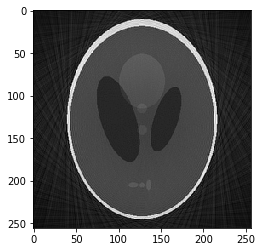

In [11]:
image1 = adjnufft(dcomp * nufft(image, ktraj), ktraj)

plot_helper(image1)

And the Toeplitz version...

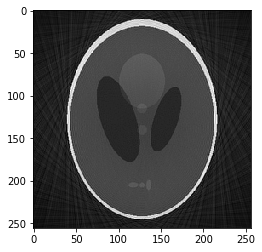

In [12]:
image2 = toepnufft(image, dcomp_kern)

plot_helper(image2)